In [1]:
import numpy as np
import os
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout, concatenate

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [2]:
from keras.layers import Lambda, GlobalAveragePooling2D, MaxPooling2D, Concatenate
from tensorflow.keras import backend, callbacks, optimizers

In [3]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')


In [4]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train = train_df.iloc[:,1:]
y_train = train_df.iloc[:,:1]

X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,:1]

In [6]:
x_train = X_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = X_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.

In [7]:
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')

print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (60000, 28, 28, 1) 1.0
Testing (10000, 28, 28, 1) 1.0


In [8]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]

print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [9]:
def gen_random_batch(in_groups, batch_halfsize = 8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size = batch_halfsize)
        out_img_a += [in_groups[c_idx]
        [np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i!=c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx]
        [np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
        
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)


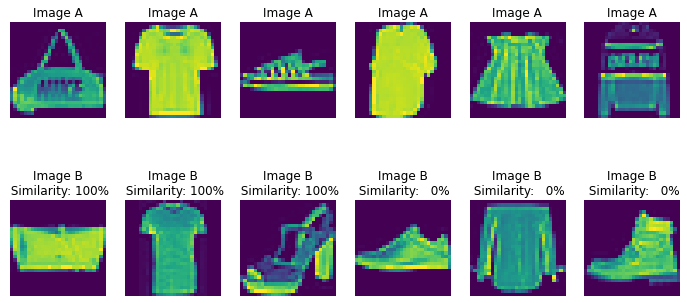

In [10]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)

fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [11]:
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
    x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
    x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
    
    if act:
        x = Activation('relu',name=name+'conv2d'+'act')(x)
    
    return x

In [12]:
# Inception ResNet A block

def incresA(x,scale,pad = 'same',name=None):
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay


In [13]:
# Inception ResNet B block

def incresB(x,scale,pad = 'same',name=None):
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

In [14]:
# Inception ResNet C block

def incresC(x,scale,pad = 'same',name=None):
    branch0 = conv2d(x,192,1,1,pad,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

In [15]:
# Stem block
def stemp_block(img_input):

    #img_input = Input(shape = x_train.shape[1:], name = 'FeatureNet_ImageInput')

    x = conv2d(img_input,32,3,2,'same',True,name='conv1')
    x = conv2d(x,32,3,1,'same',True,name='conv2')
    x = conv2d(x,64,3,1,'same',True,name='conv3')

    x_11 = MaxPooling2D(1,strides=1,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
    x_12 = conv2d(x,64,3,1,'same',True,name='stem_br_12')

    x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

    x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
    x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
    x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
    x_21 = conv2d(x_21,96,3,1,'same',True,name='stem_br_214')

    x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
    x_22 = conv2d(x_22,96,3,1,'same',True,name='stem_br_222')

    x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

    x_31 = conv2d(x,192,3,1,'same',True,name='stem_br_31')
    x_32 = MaxPooling2D(3,strides=1,padding='same',name='stem_br_32'+'_maxpool_2')(x)
    x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

    return x

In [16]:
#reduction module A

def reduction_A(x):
    x_red_11 = MaxPooling2D(3,strides=2,padding='same',name='red_maxpool_1')(x)

    x_red_12 = conv2d(x,384,3,2,'same',name='x_red1_c1')

    x_red_13 = conv2d(x,256,1,1,'same',name='x_red1_c2_1')
    x_red_13 = conv2d(x_red_13,256,3,1,'same',name='x_red1_c2_2')
    x_red_13 = conv2d(x_red_13,384,3,2,'same',name='x_red1_c2_3')

    x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

    return x

In [17]:
#reduction module B

def reduction_B(x):
    x_red_21 = MaxPooling2D(3,strides=3,padding='same',name='red_maxpool_2')(x)

    x_red_22 = conv2d(x,256,1,1,'same',name='x_red2_c11')
    x_red_22 = conv2d(x_red_22,384,3,2,'valid',name='x_red2_c12')

    x_red_23 = conv2d(x,256,1,1,'same',name='x_red2_c21')
    x_red_23 = conv2d(x_red_23,256,3,2,'valid',name='x_red2_c22')

    x_red_24 = conv2d(x,256,1,1,'same',name='x_red2_c31')
    x_red_24 = conv2d(x_red_24,256,3,1,'same',name='x_red2_c32')
    x_red_24 = conv2d(x_red_24,256,3,2,'valid',name='x_red2_c33')


    x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

    return x

In [21]:
# Inception-ResNet Network
img_input = Input(shape = x_train.shape[1:], name = 'Inception-ResNet_ImageInput')

x = stemp_block(img_input)

for i in range(10):
    x = incresA(x,0.15,name=f'incresA_{i+1}-')

x = reduction_A(x)

for i in range(20):
    x = incresB(x,0.15,name=f'incresB_{i+1}-')

x = reduction_B(x)

for i in range(10):
    x = incresC(x,0.15,name=f'incresC_{i+1}-')

x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Flatten()(x)
x = Dense(64)(x)

In [22]:
model = Model(img_input,x,name='inception_resnet_v2')
              
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inception-ResNet_ImageInput (I  [(None, 28, 28, 1)]  0          []                               
 nputLayer)                                                                                       
                                                                                                  
 conv1conv2d (Conv2D)           (None, 14, 14, 32)   288         ['Inception-ResNet_ImageInput[0][
                                                                 0]']                             
                                                                                                  
 conv1conv2dbn (BatchNormalizat  (None, 14, 14, 32)  96          ['conv1conv2d[0][0]']            
 ion)                                                                           

In [23]:
img_a_in = Input(shape = x_train.shape[1:], name = 'ImageA_Input')
img_b_in = Input(shape = x_train.shape[1:], name = 'ImageB_Input')


# img_a_feat = feature_model(img_a_in)
# img_b_feat = feature_model(img_b_in)

img_a_feat = model(img_a_in)
img_b_feat = model(img_b_in)


combined_features = concatenate([img_a_feat, img_b_feat], name ='merge_features')
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = Model(inputs = [img_a_in, img_b_in], outputs =
[combined_features], name = 'Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 64)          52183680    ['ImageA_Input[0][0]',           
 l)                                                               'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 128)          0           ['inception_resnet

In [24]:
# setup the optimization process
opt = optimizers.Adam(learning_rate=0.01)
similarity_model.compile(optimizer=opt, loss = 'binary_crossentropy',metrics = ['mae'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=0, min_lr=0.0001, verbose=1)


In [25]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

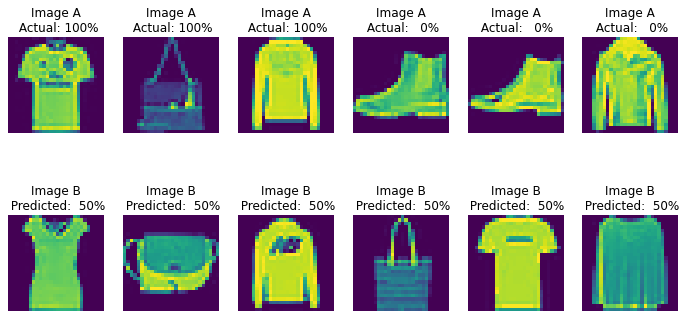

In [26]:
# a completely untrained model
_ = show_model_output()

In [27]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch = 500,
                                              callbacks=reduce_lr,
                                              validation_data=([valid_a, valid_b],valid_sim),
                                              epochs = 5,
                                              verbose = True)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


500/500 [==============================] - 295s 504ms/step - loss: 0.5090 - mae: 0.3461 - val_loss: 0.6211 - val_mae: 0.2369 - lr: 0.0100
Epoch 2/5
500/500 [==============================] - 244s 487ms/step - loss: 0.4186 - mae: 0.2722 - val_loss: 0.4025 - val_mae: 0.2220 - lr: 0.0100
Epoch 3/5
500/500 [==============================] - 244s 488ms/step - loss: 0.3795 - mae: 0.2438 - val_loss: 0.3721 - val_mae: 0.2255 - lr: 0.0100
Epoch 4/5
500/500 [==============================] - 244s 487ms/step - loss: 0.3597 - mae: 0.2305 - val_loss: 0.2879 - val_mae: 0.1728 - lr: 0.0100
Epoch 5/5
500/500 [==============================] - 244s 488ms/step - loss: 0.3213 - mae: 0.2017 - val_loss: 0.2857 - val_mae: 0.1520 - lr: 0.0100


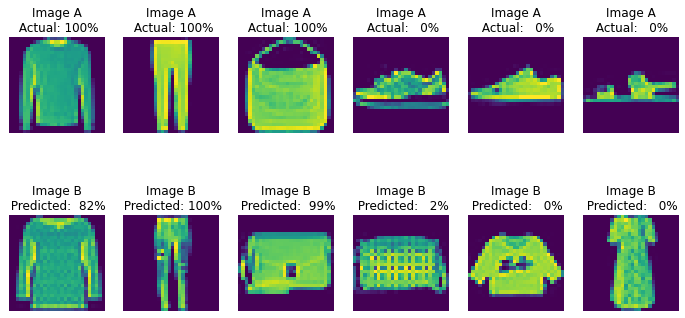

In [28]:
_ = show_model_output()

In [29]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose = True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose = True, batch_size = 128)

obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))

79/79 [==============================] - 33s 421ms/step


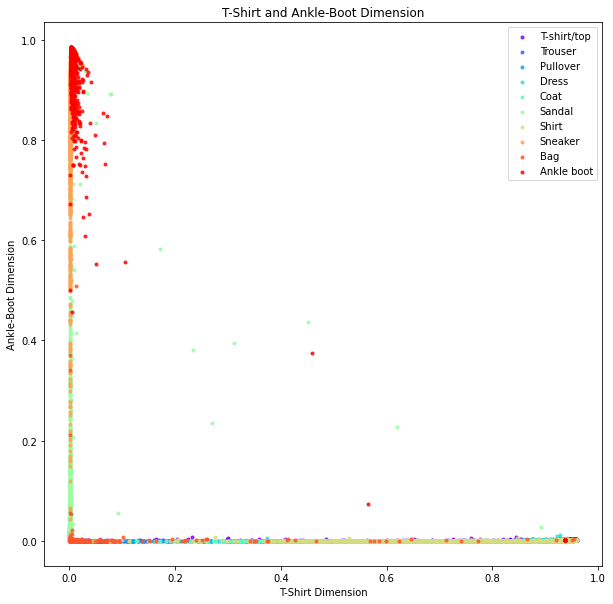

In [30]:
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(t_shirt_score[np.where(y_test == c_group), 0],
                ankle_boot_score[np.where(y_test == c_group), 0],
                marker='.', color=c_color,
                linewidth=1, alpha=0.8, label=c_label)
    
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)


In [31]:
x_test_features = model.predict(x_test, verbose = True, batch_size=128)

79/79 [==============================] - 19s 209ms/step


In [32]:
tsne_obj = TSNE(n_components=2, init='pca', random_state=101,
                method='barnes_hut', n_iter=500, verbose=2)

tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.002s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 10000 samples in 2.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 67.812837
[t-SNE] Computed conditional probabilities in 0.559s


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] Iteration 50: error = 46.7881584, gradient norm = 0.0028261 (50 iterations in 4.879s)
[t-SNE] Iteration 100: error = 85.6486664, gradient norm = 0.0070678 (50 iterations in 4.743s)
[t-SNE] Iteration 150: error = 87.3158264, gradient norm = 0.0082238 (50 iterations in 4.789s)
[t-SNE] Iteration 200: error = 86.4958801, gradient norm = 0.0078994 (50 iterations in 4.835s)
[t-SNE] Iteration 250: error = 85.3621979, gradient norm = 0.0074251 (50 iterations in 4.653s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.362198
[t-SNE] Iteration 300: error = 1.5822529, gradient norm = 0.0012845 (50 iterations in 4.409s)
[t-SNE] Iteration 350: error = 1.1775453, gradient norm = 0.0004194 (50 iterations in 4.448s)
[t-SNE] Iteration 400: error = 1.0716035, gradient norm = 0.0002108 (50 iterations in 4.490s)
[t-SNE] Iteration 450: error = 1.0275340, gradient norm = 0.0001322 (50 iterations in 4.552s)
[t-SNE] Iteration 500: error = 1.0030822, gradient norm = 0.0000960 (50 

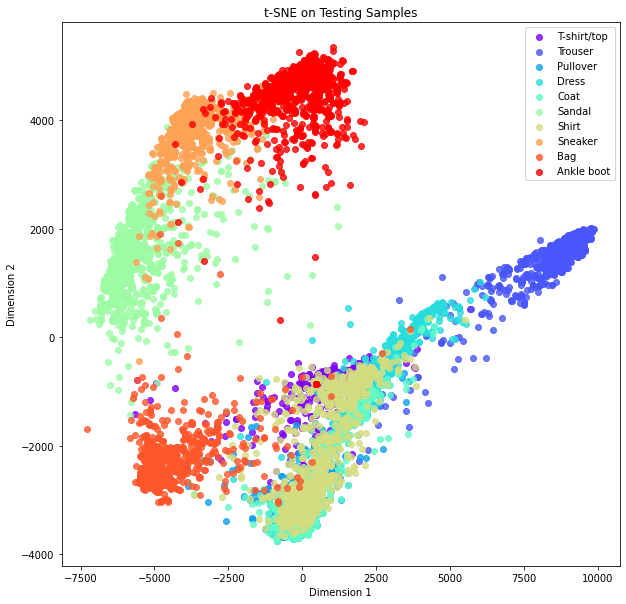

In [33]:
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o', color=c_color,
        linewidth=1, alpha=0.8, label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)